In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from scipy import stats
SEED=4242
rnd.seed(10)
SIZE=30000
ALPHA=0.03
from IPython.display import clear_output

In [254]:
df= pd.read_csv('/content/DFORE450.zip', compression='zip', low_memory=True)

In [255]:
print(df.shape)
df.drop_duplicates(subset= 'email_address', keep='last', inplace= True)
print(df.shape)

(79323, 669)
(76493, 669)


In [256]:
df.set_index('email_address', inplace=True)

## BDEX Data

In [257]:
for s in ['COMPUTERS_INTERNET', 'SHOPPING_CLOTHING', 'SHOPPING_HOMEANDGARDEN']:
  subslct= list(filter(lambda x: s in x, df.columns.tolist()))
  df[s]= df[subslct].fillna(0).sum(axis=1)

In [258]:
df['Age']= 2020- df['birth_year']

In [259]:
df.Age.fillna(df.Age.median(), inplace= True)

In [260]:
df.Age.isna().sum()

0

In [261]:
df.gender.fillna(df.gender.mode()[0], inplace=True)

In [262]:
allCols= ['AvgDaysBetweenVends', 'WalletLoad_Recency', 'Vend_Recency', 'Vend_DaysonBook', 'WalletLoad_DaysonBook', \
          'Vend_FrequencyLast180Days', 'WalletLoadAmountLast180Days', 'COMPUTERS_INTERNET', 'SHOPPING_CLOTHING', 'SHOPPING_HOMEANDGARDEN']

In [263]:
df['Recency']= df[['WalletLoad_Recency', 'Vend_Recency']].min(axis=1)

In [264]:
df['MoB']= df[['Vend_DaysonBook', 'WalletLoad_DaysonBook']].max(axis=1)

In [265]:
# df=df.loc[:, allCols]

In [266]:
rfmcols= ['AvgDaysBetweenVends', 'Recency', 'MoB','Vend_FrequencyLast180Days', 'WalletLoadAmountLast180Days']

In [267]:
df1= df.loc[:, rfmcols]

In [268]:
df1.dropna(inplace=True)

In [269]:
print(df1.shape)
for r in rfmcols:
  p5= df1[r].quantile(.05)
  p95= df1[r].quantile(.95)
  df1[r] = np.where(df1[r] <p5, p5,df1[r])
  df1[r] = np.where(df1[r] >p95, p95,df1[r])
  # df= df.loc[df.loc[:, r].between(p5, p95)]
print(df1.shape)

(76475, 5)
(76475, 5)


## Clustrering

In [270]:
idx= df1.index

In [271]:
qseries= np.zeros(len(df1))
for c in df1.columns.tolist():
  qseries= qseries+ pd.qcut(df1[c], 5, labels=False, duplicates= 'drop').values+1
  print(c)

AvgDaysBetweenVends
Recency
MoB
Vend_FrequencyLast180Days
WalletLoadAmountLast180Days


In [272]:
train, test, idx_train, idx_test = train_test_split(df1, idx, test_size=0.2, shuffle= True, random_state=4242, stratify= qseries)

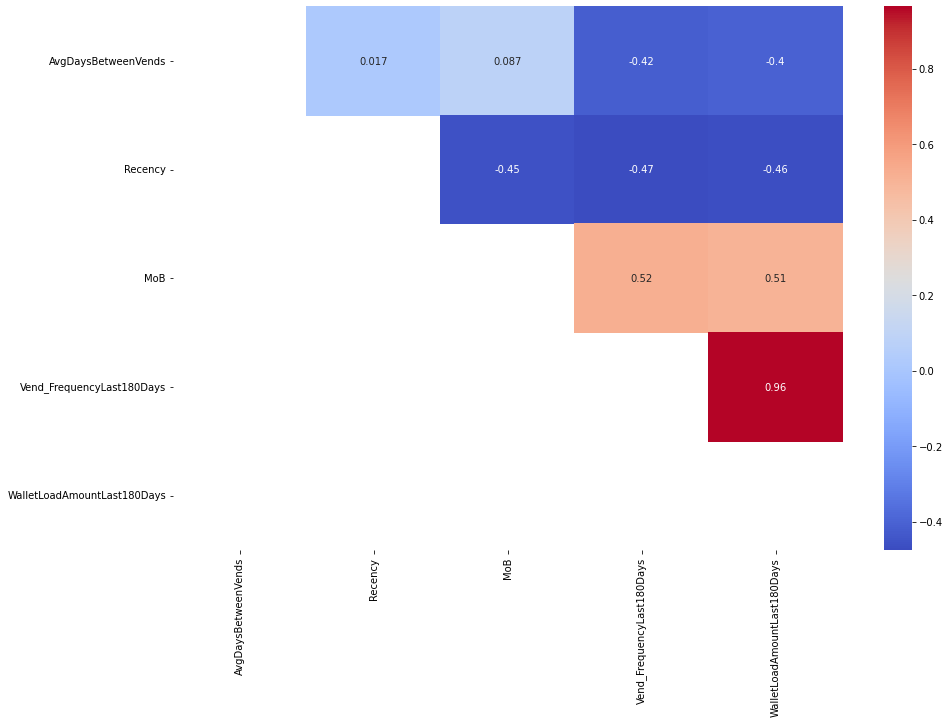

In [317]:
plt.figure(figsize = (15,10))
mask = np.tril(np.ones_like(df1.corr()))
sns.heatmap(df1.corr(), fmt='.2g',cmap='coolwarm', annot= True, mask=mask)

In [273]:
mms = MinMaxScaler()
mms.fit(df1)
train = mms.fit_transform(train)
test= mms.transform(test)

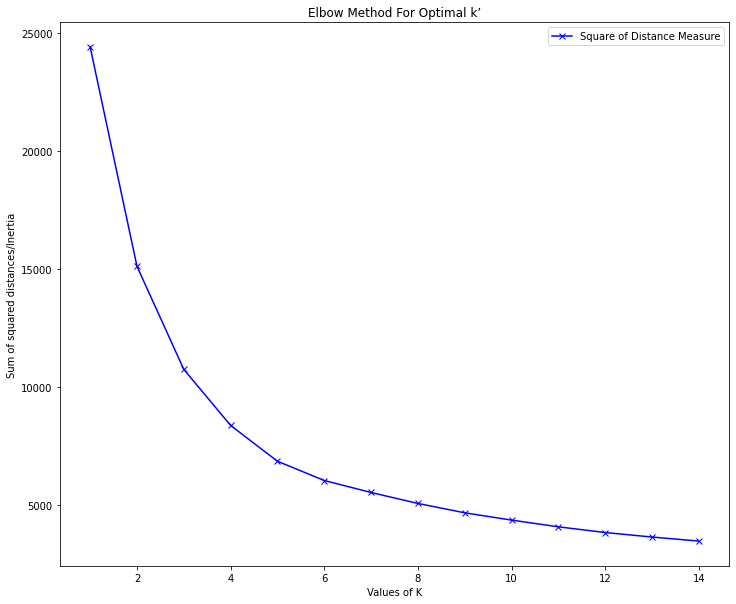

In [274]:
Sum_of_squared_distances = []
plt.figure(figsize=(12,10))
K = range(1,15)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(train)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-', label= 'Square of Distance Measure')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.legend()
plt.title('Elbow Method For Optimal k’')
plt.show()

In [275]:
range_n_clusters = range(3,10)
silhouette_avg = []
for num_clusters in range_n_clusters:
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(train)
 cluster_labels = kmeans.labels_
 # silhouette score
 silhouette_avg.append(silhouette_score(train, cluster_labels))
 clear_output(wait=True)
 print('Calculated for ', num_clusters)

Calculated for  9


In [299]:
silhouette_avg

[0.3316764878771546,
 0.34413750959104933,
 0.3285022102997843,
 0.3178217821076357,
 0.2915959281848636,
 0.29623247189008994,
 0.28850031512791563]

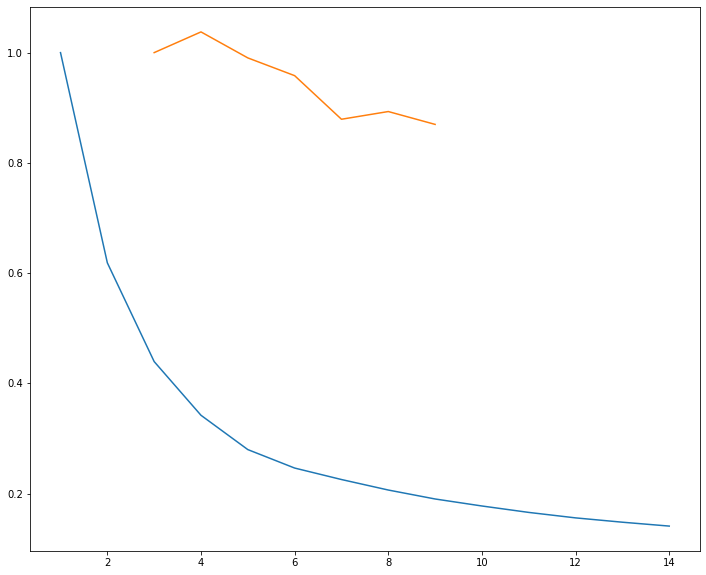

In [276]:
plt.figure(figsize=(12,10))
plt.plot(K,np.array(Sum_of_squared_distances)/ Sum_of_squared_distances[0])
plt.plot(range_n_clusters,np.array(silhouette_avg)/silhouette_avg[0])

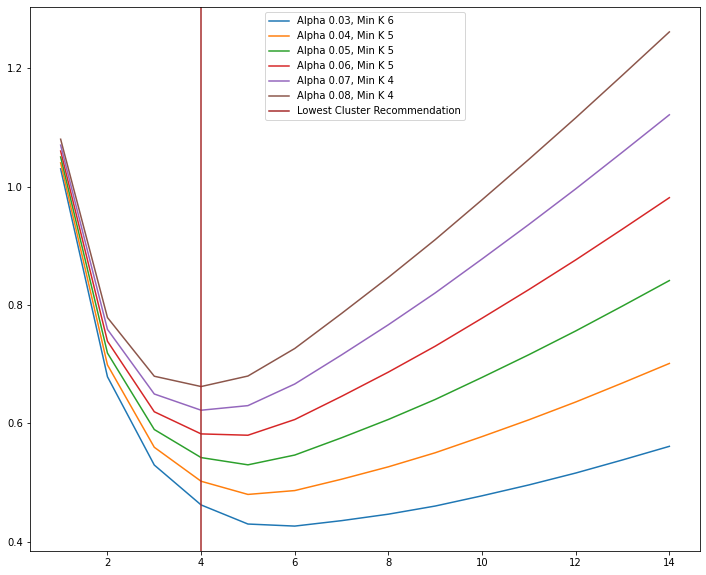

In [277]:
lminIdx=99999
plt.figure(figsize=(12,10))
for a in [.03,.040,.05,.06,.07, .08]:
  modified_intertia= np.array(Sum_of_squared_distances)/ Sum_of_squared_distances[0]+a*np.array([i+1 for i in range(len(Sum_of_squared_distances))])
  minIdx= np.argmin(modified_intertia)
  if lminIdx > minIdx:
    lminIdx= minIdx+1
  plt.plot(K, modified_intertia, label='Alpha {}, Min K {}'.format(a, minIdx+1))
plt.axvline(lminIdx, label= 'Lowest Cluster Recommendation', color= 'brown')
plt.legend()

In [278]:
lminIdx

4

In [300]:
pca = PCA(n_components= 2)
pca.fit(train)

PCA(n_components=2)

In [301]:
km = KMeans(n_clusters= 3)
km = km.fit(train)
tr_cluster_labels = km.labels_

In [302]:
df3= pd.DataFrame(pca.fit_transform(train))
df3.columns= ['PCA_1', 'PCA_2']

In [303]:
df3['cluster']= tr_cluster_labels

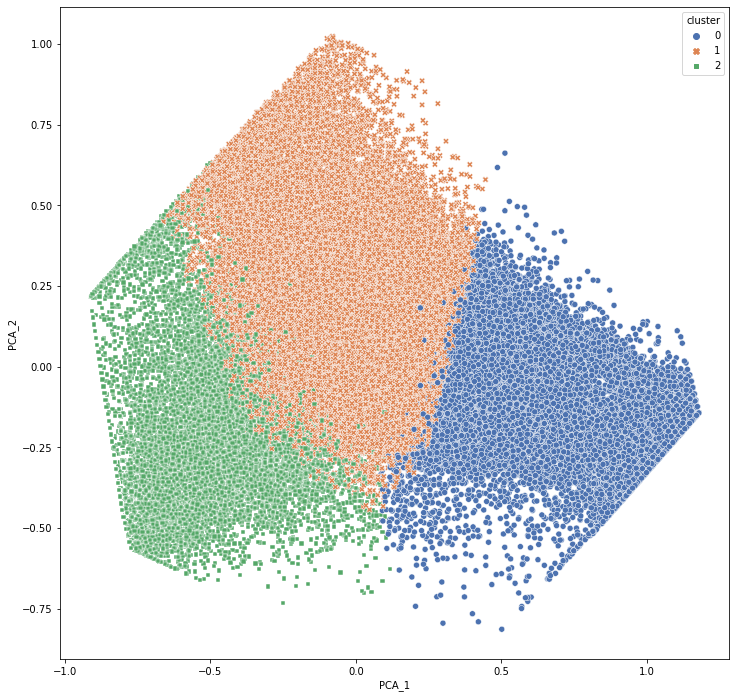

In [304]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=df3, x="PCA_1", y="PCA_2", hue="cluster", style= 'cluster', palette="deep")

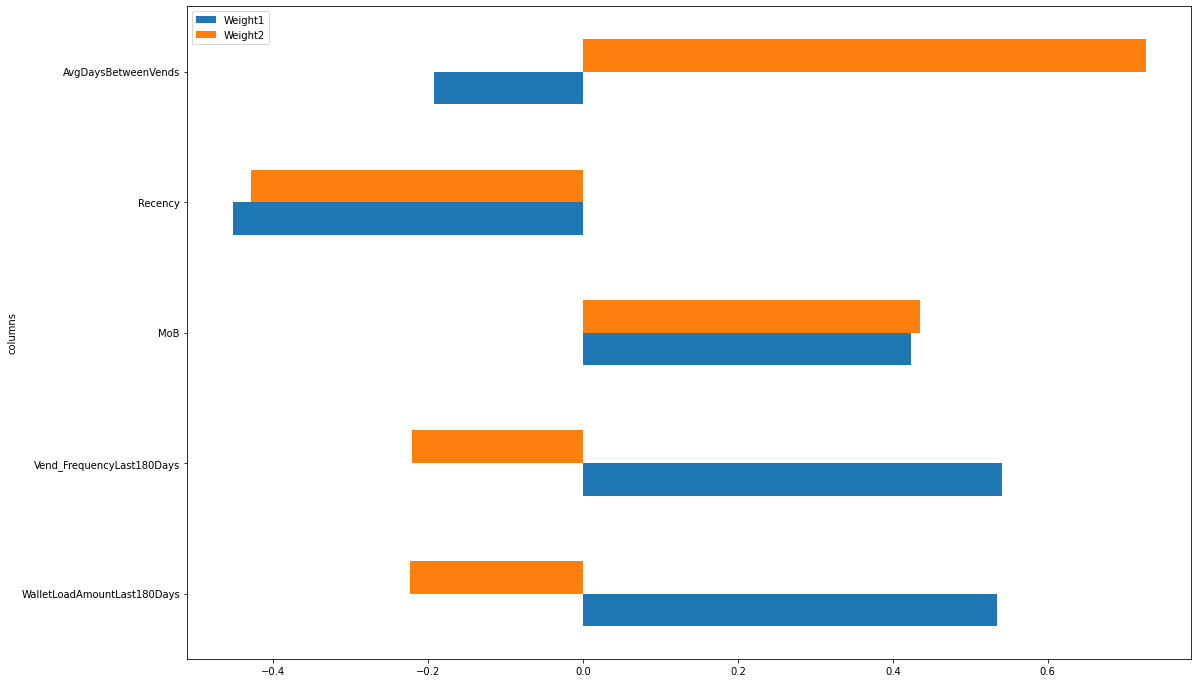

In [305]:
weights = pca.components_
df4=pd.DataFrame({
    'columns': list(df1.columns),
    'Weight1': list(weights[0]),
    'Weight2': list(weights[1])
})
df4['norm']= np.sqrt(df4.Weight1**2+ df4.Weight2**2)
df4.sort_values(by='norm', inplace= True, ascending= False)

# plt.figure(figsize=(18,12))
df4.sort_values('norm', ascending=True).plot(x="columns", y=["Weight1", "Weight2"], kind="barh", figsize=(18,12))

Text(0, 0.5, 'PC 1')

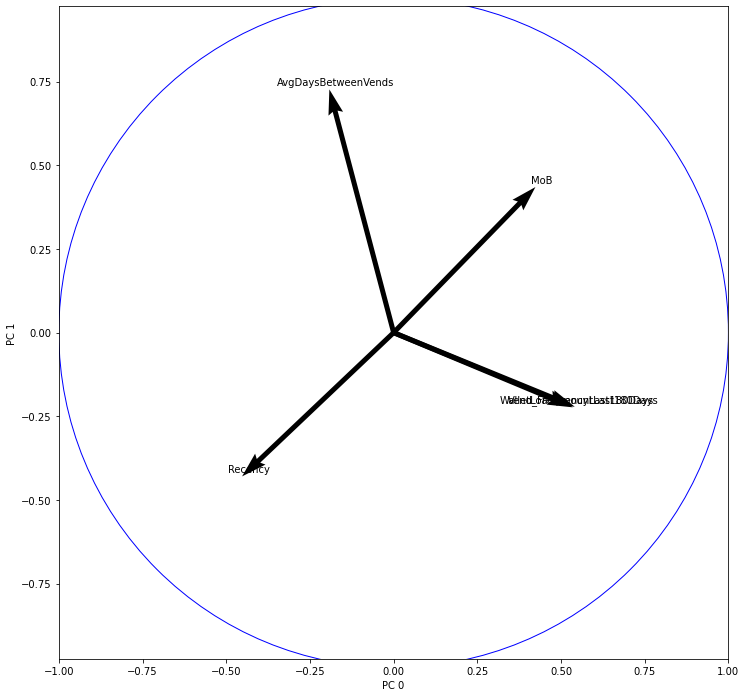

In [306]:
PCs = pca.components_

# Use quiver to generate the basic plot
fig = plt.figure(figsize=(12,12))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1)

# Add labels based on feature names (here just numbers)
feature_names = df1.columns.tolist()
for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
    plt.text(j, i, z, ha='center', va='center')

# Add unit circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
plt.axis('equal')
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])

# Label axes
plt.xlabel('PC 0')
plt.ylabel('PC 1')

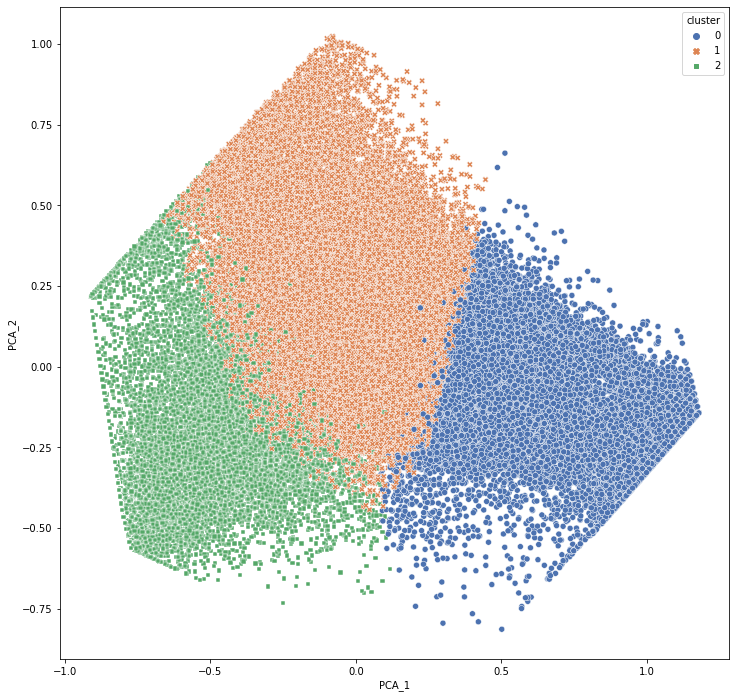

In [307]:
te_cluster_labels= km.fit_predict(test)
df4= pd.DataFrame(pca.fit_transform(test))
df4.columns= ['PCA_1', 'PCA_2']
df4['cluster']= te_cluster_labels
plt.figure(figsize=(12,12))
sns.scatterplot(data=df3, x="PCA_1", y="PCA_2", hue="cluster", style= 'cluster', palette="deep")

In [308]:
df6=pd.concat(
[pd.DataFrame({'email_address': list(idx_train), 'Cluster': list(tr_cluster_labels),'flag': ['train']*len(tr_cluster_labels)}),
pd.DataFrame({'email_address': list(idx_test), 'Cluster': list(te_cluster_labels),'flag': ['train']*len(te_cluster_labels) })], axis=0)
df6.set_index('email_address', inplace= True)

In [309]:
df3= df1.merge(df6,left_index=True, right_index= True, how='inner')
df2= df.merge(df6,left_index=True, right_index= True, how='inner')

In [310]:
print(df6.shape)
print(df1.shape)
print(df.shape)
print(df3.shape)
print(df2.shape)

(76475, 2)
(76475, 5)
(76493, 674)
(76475, 7)
(76475, 676)


In [311]:
# recs=[]
# for col in gcols:
#   for c1 in df1.cluster.unique():
#     for c2 in df1.cluster.unique():
#       if c1 != c2:
#         sz1= df1.loc[df1.flag=='train'].groupby('cluster')[gcols].describe().T.loc[(col, 'count')][c1]
#         m1= df1.loc[df1.flag=='train'].groupby('cluster')[gcols].describe().T.loc[(col, 'mean')][c1]
#         s1= df1.loc[df1.flag=='train'].groupby('cluster')[gcols].describe().T.loc[(col, 'std')][c1]**2
#         sz2= df1.loc[df1.flag=='train'].groupby('cluster')[gcols].describe().T.loc[(col, 'count')][c2]
#         m2= df1.loc[df1.flag=='train'].groupby('cluster')[gcols].describe().T.loc[(col, 'mean')][c2]
#         s2= df1.loc[df1.flag=='train'].groupby('cluster')[gcols].describe().T.loc[(col, 'std')][c2]**2
#         t, p = stats.ttest_ind(df1.loc[(df1.flag=='train') & (df1.cluster== c1), c].values, df1.loc[(df1.flag=='train') & (df1.cluster== c2), c].values, equal_var = True)
#         print(col, c1,c2, round(m1,2),round(s1,2),round(m2,2),round(s2,2),round(t,2),round(p,2))
#         recs.append([col, c1,c2, round(m1,2),round(s1,2),round(m2,2),round(s2,2),round(t,2),round(p,2)])
#         clear_output(wait=True)

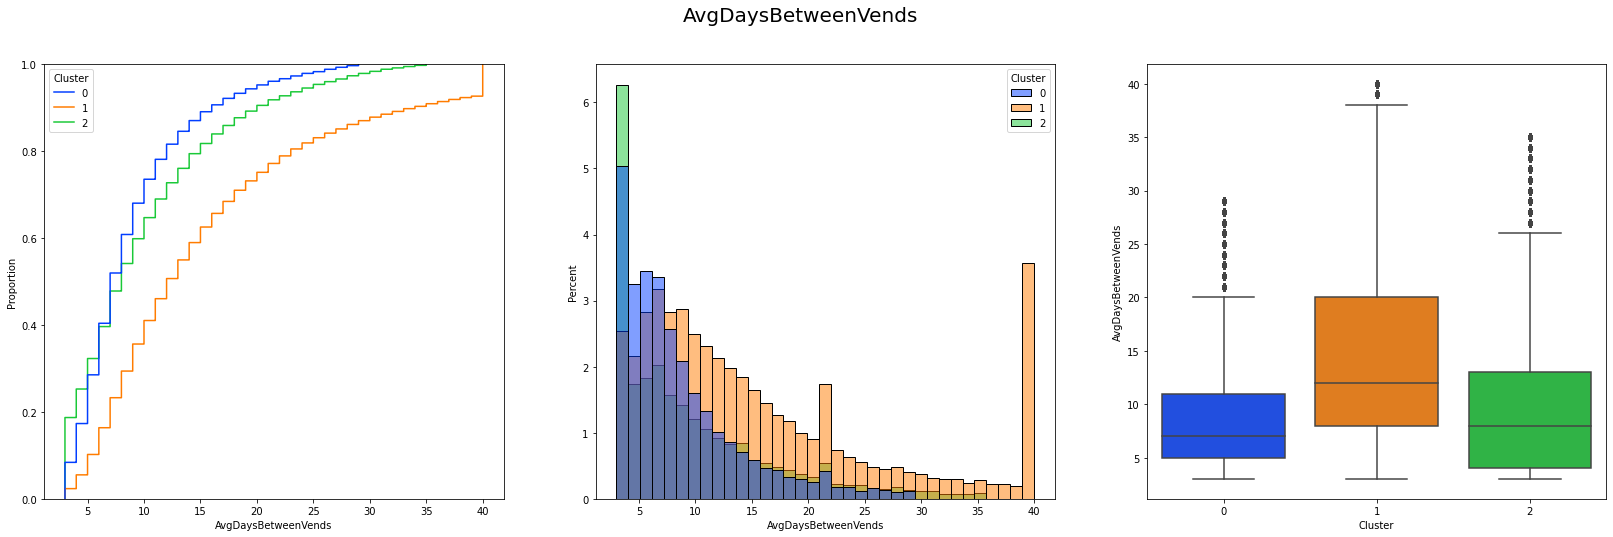

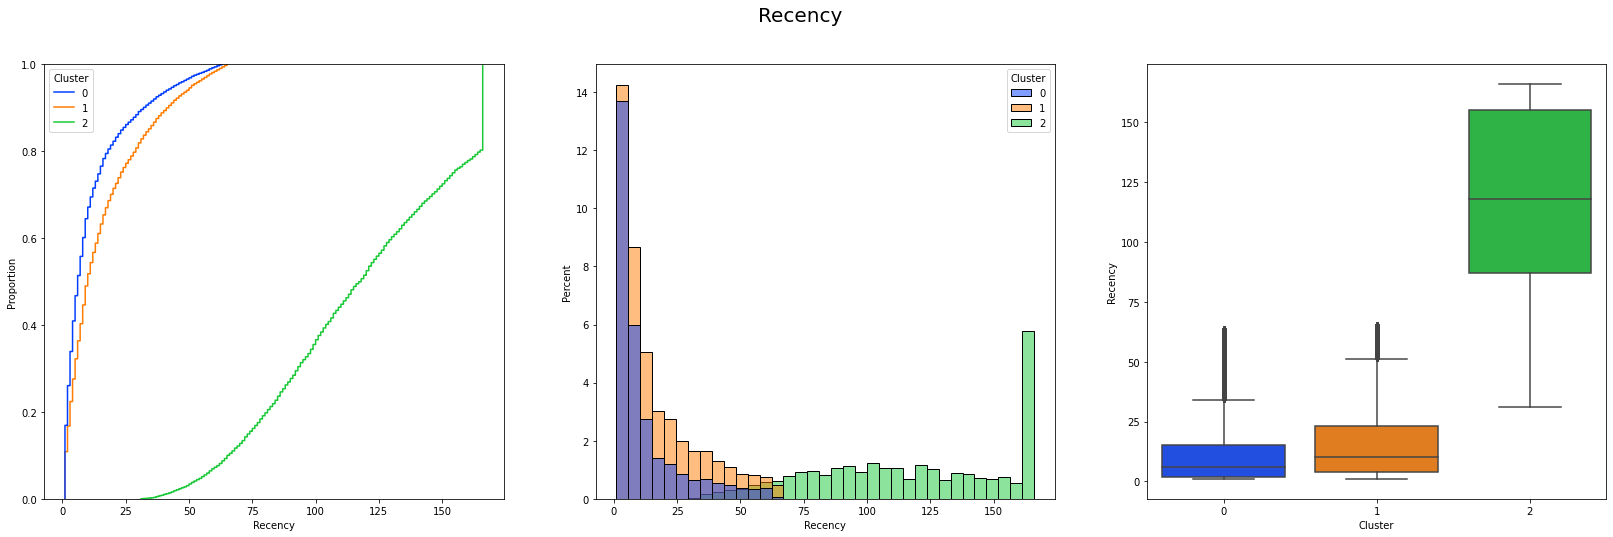

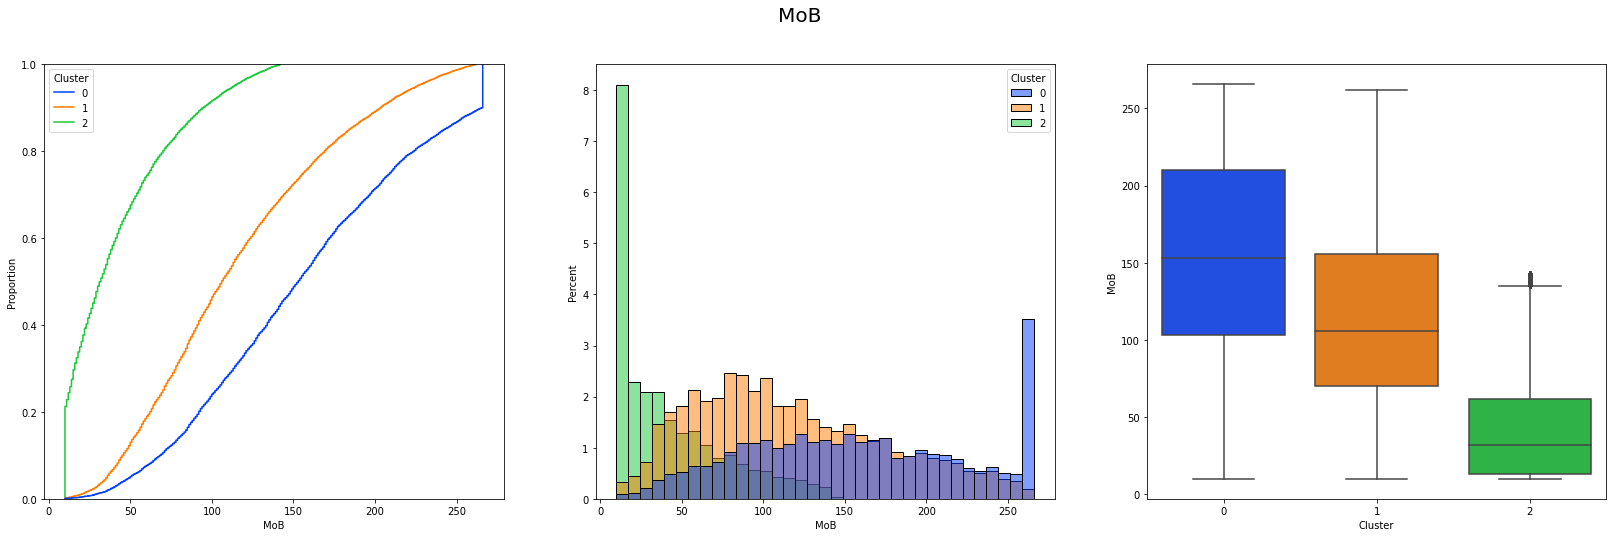

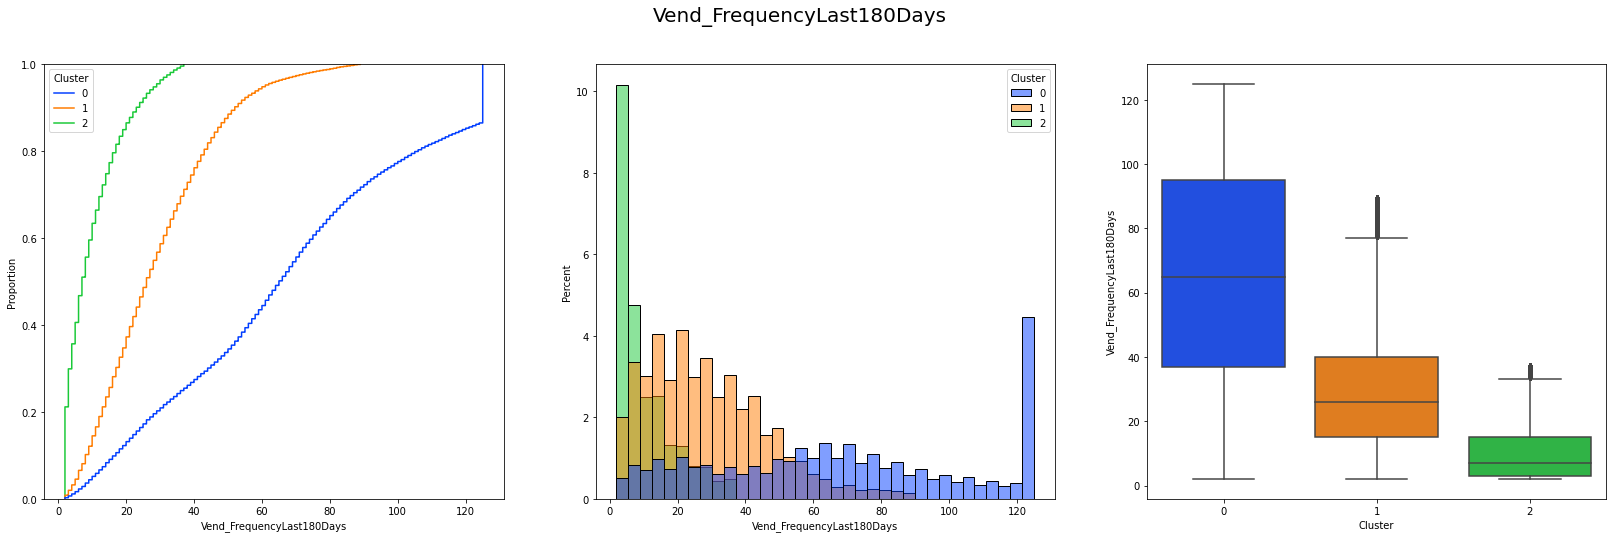

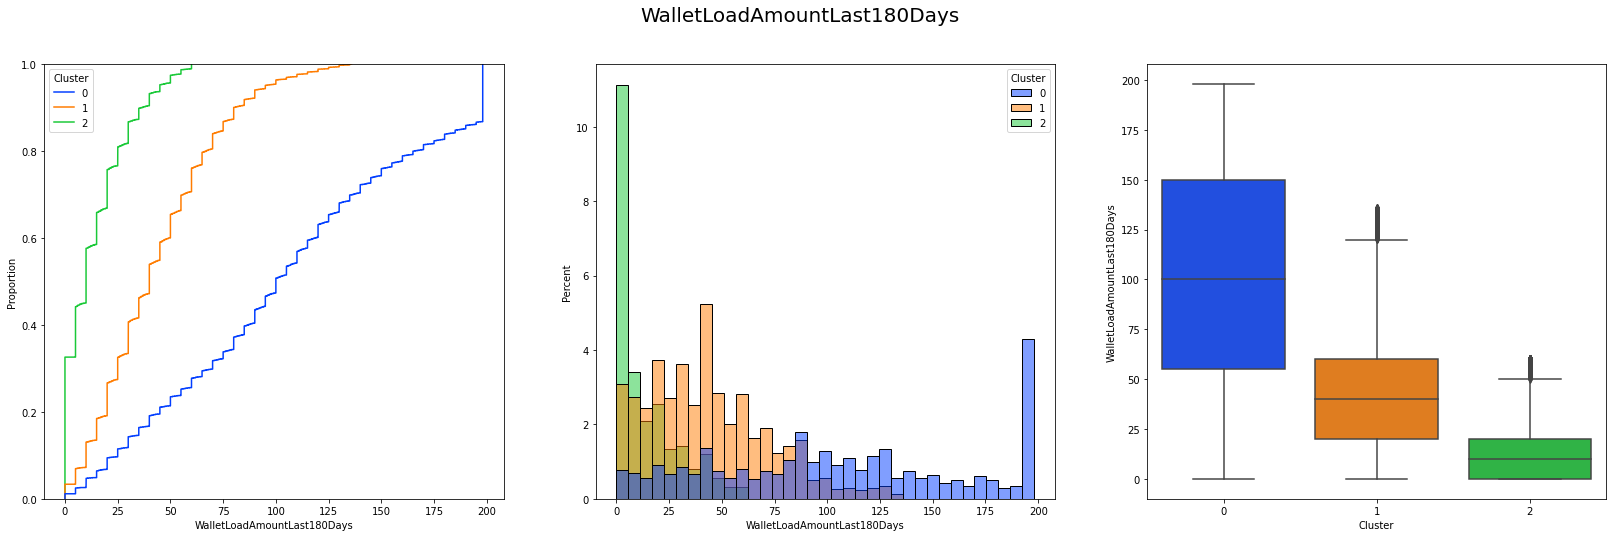

In [312]:
for c in rfmcols:
  gf1= df3.loc[df3.flag=='train']
  gf2=gf1.groupby('Cluster')[c].quantile(.95).reset_index()
  gf1= gf1.merge(gf2, how='inner', on= 'Cluster', suffixes=('', '_y'))
  gf1=gf1.loc[gf1.loc[:,c] <= gf1.loc[:,c+'_y']]
  fig, axes = plt.subplots(1,3,figsize=(28,8), sharey= False)
  # gf2= df1.loc[df1.flag=='test']
  fig.suptitle(c, fontsize=20)
  sns.ecdfplot(gf1, x= c, ax=axes[0], hue= 'Cluster', palette='bright')
  # sns.ecdfplot(gf2, x= c, ax=axes[1,0], hue= 'cluster', palette='bright')
  sns.histplot(gf1, x= c, ax=axes[1], hue= 'Cluster', palette='bright', stat= 'percent', bins=35)
  # sns.histplot(gf2, x= c, ax=axes[1,1], hue= 'cluster', palette='bright')
  sns.boxplot(data=gf1, x= 'Cluster', y=c, palette='bright')
  # sns.boxplot(gf2, x= c, ax=axes[1,1], hue= 'cluster', palette='bright')
  # fig.tight_layout()
  # fig.subplots_adjust(top=0.90)
  plt.show()
  # plt.close()

In [313]:
# gcols= ['AvgDaysBetweenVends', 'MaxDaysonBooks', 'MostRecent',
#        'Vend_FrequencyLast180Days', 'WalletLoadAmountLast180Days', 'Age',
#        'COMPUTERS_INTERNET', 'SHOPPING_CLOTHING', 'SHOPPING_HOMEANDGARDEN',
#        'gender_F']

## Classification with BDEX data

In [318]:
df2= pd.get_dummies(df2, columns=['gender'])

In [330]:
df7=df2[['Age', 'COMPUTERS_INTERNET', 'SHOPPING_CLOTHING', 'SHOPPING_HOMEANDGARDEN', 'gender_F', 'Cluster']]

In [338]:
features= ['Age', 'COMPUTERS_INTERNET', 'SHOPPING_CLOTHING', 'SHOPPING_HOMEANDGARDEN', 'gender_F']

In [331]:
cf= ['Age', 'COMPUTERS_INTERNET', 'SHOPPING_CLOTHING', 'SHOPPING_HOMEANDGARDEN']

In [333]:
print(df7.shape)
for r in cf:
  p5= df7[r].quantile(.01)
  p95= df7[r].quantile(.99)
  df7[r] = np.where(df7[r] <p5, p5,df7[r])
  df7[r] = np.where(df7[r] >p95, p95,df7[r])
  # df= df.loc[df.loc[:, r].between(p5, p95)]
print(df7.shape)

(76475, 6)
(76475, 6)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [339]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(df7[features], df7.Cluster, df7.index, random_state = 4242, shuffle= True)

In [350]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
dtree_model = DecisionTreeClassifier(max_depth = 3).fit(X_train.values, y_train.values)
dtree_predictions = dtree_model.predict(X_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, dtree_predictions)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [353]:
dtree_predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)